In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()
sns.set_style('darkgrid')
sns.set_context('notebook')

%matplotlib inline

pd.options.mode.chained_assignment = None

# First Glance

In [2]:
# load data
train_variants_df = pd.read_csv("data/training_variants")
test_variants_df = pd.read_csv("data/test_variants")
train_text_df = pd.read_csv("data/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv("data/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

print("Train and Test variants shape : ",train_variants_df.shape, test_variants_df.shape)
print("Train and Test text shape : ",train_text_df.shape, test_text_df.shape)

Train and Test variants shape :  (3321, 4) (5668, 3)
Train and Test text shape :  (3321, 2) (5668, 2)


In [3]:
test_variants_df.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [4]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
# join variants data with text data
training = train_variants_df.merge(right=train_text_df, on='ID')
testing = test_variants_df.merge(right=test_text_df, on='ID')

# join variants df together for comparison
# though the test set won't be used to train the classifier
train_variants_df['set'] = 'training'
test_variants_df['set'] = 'testing'
variants_df = pd.concat([train_variants_df, test_variants_df])

# Class and Variants

In [ ]:
training.info()

In [ ]:
# Notice there are 5 rows with null texts. We'll drop these rows.
training.dropna(inplace=True)

In [ ]:
# Look at class distribution, only available in training set

plt.figure(figsize=(12,5))
sns.countplot(x="Class", data=train_variants_df, color='grey')
# training.Class.value_counts().plot(kind='bar')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class number', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

There's an uneven distribution of each classes. What do each of these classes mean? A quick web search produced no answers.

In [ ]:
# plot the top 20 genes from the overall dataset
plt.figure(figsize=(12,5))
sns.countplot(data=variants_df,
             x='Gene',
             hue='set',
             order=variants_df.Gene.value_counts().iloc[:20].index)
plt.xticks(rotation=30)
plt.show()


In [ ]:
# plot the top 20 Variations from the overall dataset
# get top 20 variations to plot
largest20_idx = variants_df.Variation.value_counts().nlargest(20).index
largest20 = variants_df.loc[variants_df.Variation.isin(list(largest20_idx))]

plt.figure(figsize=(12,5))
sns.countplot(data=largest20,
             x='Variation',
             hue='set',
             )
plt.xticks(rotation=30, ha='right')
plt.show()

In [ ]:
# plot the top 20 Variations from the overall dataset by proportion

plt.figure(figsize=(12,5))
sns.histplot(data = largest20,
             x = 'Variation',
             hue='set',
             multiple="dodge", 
             stat = 'density', #this will make the y-axis the density rather than count
             shrink = 0.8, 
             common_norm=False, # this will normalize each density independently
             )
plt.xticks(rotation=30, ha='right')
plt.show()

proportions of the variations in train/test sets seem similar

In [ ]:
display(training[training['Gene'] == 'BRCA1'])

In [ ]:
# top 9 most frequently mentioned genes vs their class counts
fig, axs = plt.subplots(3,3, sharex=True, figsize=(12,5))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Gene vs Class Counts", fontsize=18, y=1)
for gene, ax in zip(list(training['Gene'].value_counts().nlargest(9).index),axs.ravel()):
    training[training['Gene'] == gene].Class.value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f"{gene}", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")

# add common x and y labels    
fig.add_subplot(111, frameon=False)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class number', fontsize=12)
plt.grid(visible=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.show()

For a single gene, there may be different mutations resulting in different classes

Within a single paper, there may be descriptions of multiple variations which need multiple class labels.

# Text data

In [ ]:
# does the paper call out specific mutations?
mutations = ['E1735K','A1843T','D1778G']
for mutation in mutations:
    print(mutation in training.iloc[2417]['Text'])
    
# not necessarily!?

In [ ]:
training["num_words"] = training["Text"].apply(lambda x: len(str(x).split()) )
plt.figure(figsize=(12, 8))
sns.distplot(training.num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

The documents we are classifying are of various lengths

In [ ]:
# look at a specific document
import textwrap
print(textwrap.fill(train_text_df.loc[0,'Text'],88))

## Class vs keywords - NLTK
Can we find keywords definining each class?

plan:
* break each document down into tokens
* look at word frequency per class
* remove stop words
* remove numbers?
* combine similar words (i.e., mutation vs mutations) - byte-pair encoding, Unigrams. We use the Huggingface Tokenizers library for these.

In [7]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/kfchou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kfchou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# this tokenizer keeps punctuations
tokens = word_tokenize(train_text_df.loc[0,'Text'])
fdist = FreqDist(tokens)
fdist

In [ ]:
# get words only
tokenizer = RegexpTokenizer(pattern=r"\w+") # uses regex to match delimiters
tokens = tokenizer.tokenize(train_text_df.loc[0,'Text'])
fdist = FreqDist(tokens)
fdist

In [ ]:
token_dict = pd.DataFrame([list(fdist.keys()), list(fdist.values())]).T
token_dict.columns = ['token','count']
token_dict = token_dict.sort_values(by='count', ascending=False)

In [ ]:
# remove stopwords; i.e., common english words like 'a', 'an', 'the'
stop_words = set(stopwords.words('english'))
token_dict = token_dict[~token_dict['token'].isin(stop_words)]

In [ ]:
sns.barplot(
    data=token_dict.head(30),
    x='count',
    y='token'
)

now do for classes

In [ ]:
tokenizer = RegexpTokenizer(pattern=r"\w+") 
stop_words = set(stopwords.words('english'))

def tokenize(str):
    tokens = tokenizer.tokenize(str)
    
    # get word distribution
    fdist = FreqDist(tokens) 
    
    # return dataframe
    token_dict = pd.DataFrame([list(fdist.keys()), list(fdist.values())]).T
    token_dict.columns = ['token','count']
    token_dict = token_dict.sort_values(by='count', ascending=False)
    
    # remove stopwords; i.e., common english words like 'a', 'an', 'the'
    token_dict = token_dict[~token_dict['token'].isin(stop_words)]
    
    sns.barplot(
        data=token_dict.head(30),
        x='count',
        y='token'
    )
    plt.show()

In [ ]:
class1 = training[training['Class'] == 1]['Text'].str.cat(sep=' ')
tokenize(class1)

## Class vs keywords - HuggingFace
https://towardsdatascience.com/training-bpe-wordpiece-and-unigram-tokenizers-from-scratch-using-hugging-face-3dd174850713

In [8]:
## importing the tokenizer and subword BPE trainer
from tokenizers import Tokenizer
from tokenizers.models import BPE, Unigram, WordLevel, WordPiece
from tokenizers.trainers import (BpeTrainer, 
                                 WordLevelTrainer,
                                 WordPieceTrainer,
                                 UnigramTrainer)
## a pretokenizer to segment the text into words
from tokenizers.pre_tokenizers import Whitespace

In [9]:
unk_token = "<UNK>"  # token for unknown words
spl_tokens = ["<UNK>", "<SEP>", "<MASK>", "<CLS>"]  # special tokens

def prepare_tokenizer_trainer(alg):
    """
    Prepares the tokenizer and trainer with unknown & special tokens.
    """
    if alg == 'BPE':
        tokenizer = Tokenizer(BPE(unk_token = unk_token))
        trainer = BpeTrainer(special_tokens = spl_tokens)
    elif alg == 'UNI':
        tokenizer = Tokenizer(Unigram())
        trainer = UnigramTrainer(unk_token= unk_token, special_tokens = spl_tokens)
    elif alg == 'WPC':
        tokenizer = Tokenizer(WordPiece(unk_token = unk_token))
        trainer = WordPieceTrainer(special_tokens = spl_tokens)
    else:
        tokenizer = Tokenizer(WordLevel(unk_token = unk_token))
        trainer = WordLevelTrainer(special_tokens = spl_tokens)
    
    tokenizer.pre_tokenizer = Whitespace()
    return tokenizer, trainer

def train_tokenizer(iterable, alg='WLV', use_pretrained=True):
    """
    Takes the files and trains the tokenizer.
    
    Args:
        iterable - a python iterable
        alg: WLV - word level algo
             WPC - word piece algo
             BPE - byte pair encoding
             uni - unigram
    """
    if use_pretrained:
        try:
            tokenizer = Tokenizer.from_file(f"./{alg}_tokenizer-trained.json")
        except:
            raise Exception(f'{alg}_tokenizer-trained.json is not found')
    else:
        tokenizer, trainer = prepare_tokenizer_trainer(alg)
        tokenizer.train_from_iterator(iterable, trainer) # training the tokenzier
        tokenizer.save(f"./{alg}_tokenizer-trained.json")
        tokenizer = Tokenizer.from_file(f"./{alg}_tokenizer-trained.json")
    return tokenizer

In [10]:
# train tokenizers with four algorithms
tokens_dict = {}
trained_tokenizer = {}
for alg in ['WLV', 'BPE', 'UNI', 'WPC']:
    trained_tokenizer[alg] = train_tokenizer(training['Text'], alg)


## Class-specific tokens vs global tokens

In [11]:
# remove stopwords; i.e., common english words like 'a', 'an', 'the'
stop_words = set(stopwords.words('english'))

def tokens_distribution(encoded):
    """
    given a hugging-face tokenized corpus, return a dataframe with columns:
    * token
    * count
    * len - length characters in token
    * percent - token count/total token count
    
    """
    # place tokens into dataframe & count occurance
    tokens = pd.DataFrame(encoded.tokens)
    tokens.columns = ['token']
    tokens_df = tokens.groupby('token').value_counts().to_frame()
    tokens_df.columns = ['count']
    token_count_total = tokens_df['count'].sum()
    
    # remove stopwords; i.e., common english words like 'a', 'an', 'the'
    tokens_df = tokens_df.reset_index()
    tokens_df = tokens_df[~tokens_df['token'].isin(stop_words)]
    tokens_df['len'] = tokens_df['token'].str.len()
    
    # remove short chars
    tokens_df = tokens_df[tokens_df['len']>2]
    
    # proportions
    tokens_df['percent'] = tokens_df['count']/token_count_total
    return tokens_df

In [12]:
# get token distribution for overall training data
output = trained_tokenizer['WLV'].encode(training['Text'].str.cat(sep=' '))
training_class_all_tokens_df = tokens_distribution(encoded=output)

In [62]:
# get token distributions for each training class
training_class_tokens_df_dict = dict()
for cls in range(9):
    output = trained_tokenizer['WLV'].encode(training[training['Class']==cls+1]['Text'].str.cat(sep=' '))
    training_class_tokens_df_dict[cls+1] = tokens_distribution(encoded=output)

In [66]:
import functools as ft
from copy import deepcopy

# give columns unique names
df_list = deepcopy(list(training_class_tokens_df_dict.values()))
for i, df in enumerate(df_list, start=1):
    df.rename(columns={col:f'{col}_{i}' for col in ('count', 'percent')}, 
              inplace=True)
    df.drop(columns=['len'], inplace=True)

# merge the list of dataframes
df_merged_classes = ft.reduce(
        lambda left, right: pd.merge(left, right, on='token', how='outer'),
        df_list,
        )

df_merged_classes.head()

,token,count_1,percent_1,count_2,percent_2,count_3,percent_3,count_4,percent_4,count_5,percent_5,count_6,percent_6,count_7,percent_7,count_8,percent_8,count_9,percent_9
0,"""':)",9.0,1.312351e-06,NaN,NaN,NaN,NaN,108.0,1.362817e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"""+'",4.0,5.832673e-07,NaN,NaN,NaN,NaN,48.0,6.056967e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"""::",5.0,7.290841e-07,NaN,NaN,NaN,NaN,60.0,7.571208e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,###,12.0,1.749802e-06,25.0,0.000005,NaN,NaN,4.0,5.047472e-07,NaN,NaN,NaN,NaN,121.0,0.000009,NaN,NaN,NaN,NaN
4,"%),",580.0,8.457376e-05,815.0,0.000151,44.0,0.000058,643.0,8.113811e-05,212.0,0.000092,251.0,0.000097,1864.0,0.000133,7.0,0.000027,54.0,0.000089


In [68]:
# then merge with the entire training token set
tokens_df = training_class_all_tokens_df.merge(
        right=df_merged_classes, 
        on='token', 
        how='outer',
        )
tokens_df.head()

,token,count,len,percent,count_1,percent_1,count_2,percent_2,count_3,percent_3,...,count_5,percent_5,count_6,percent_6,count_7,percent_7,count_8,percent_8,count_9,percent_9
0,"""':)",117,4,0.000003,9.0,1.312351e-06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"""+'",52,3,0.000001,4.0,5.832673e-07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"""::",65,3,0.000002,5.0,7.290841e-07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,###,162,3,0.000004,12.0,1.749802e-06,25.0,0.000005,NaN,NaN,...,NaN,NaN,NaN,NaN,121.0,0.000009,NaN,NaN,NaN,NaN
4,"%),",4470,3,0.000110,580.0,8.457376e-05,815.0,0.000151,44.0,0.000058,...,212.0,0.000092,251.0,0.000097,1864.0,0.000133,7.0,0.000027,54.0,0.000089


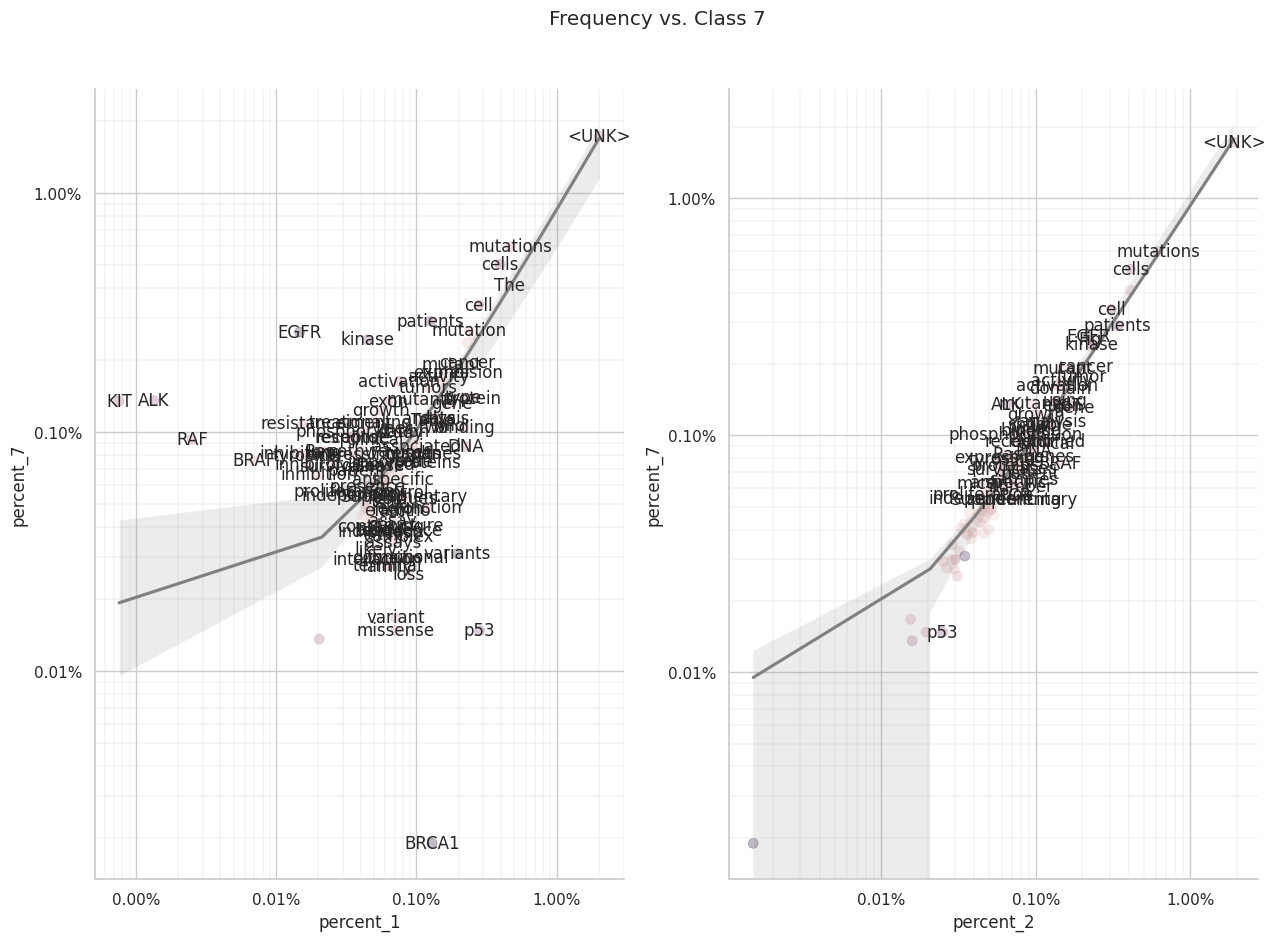

In [101]:
from matplotlib.ticker import PercentFormatter
sns.set_theme(style="whitegrid")

topn_tokens = tokens_df.sort_values(by='count',ascending=False).head(150).index

fig, axs = plt.subplots(1,2, figsize=(15,10))

def plot_scatter(xcol, ycol, ax):
    g=sns.scatterplot(
        x=xcol, 
        y=ycol,
        hue=abs(tokens_df[ycol] - tokens_df['percent']), 
        data=tokens_df.iloc[topn_tokens], 
        alpha=0.3,
        s=50,
        # size=2.5, 
        # sizes=(10, 250), 
        edgecolor=None,
        ax=ax,
        legend=False
        )
    sns.regplot(x=xcol, y=ycol, data=tokens_df.iloc[topn_tokens], scatter=False, color='gray', ax=ax)

    for index, row in tokens_df.iloc[topn_tokens].iterrows():
        if abs(row[xcol] - row[ycol]) > 0.0001:
            ax.text(row[xcol], row[ycol], row['token'], ha='center', va='center', fontsize=12)

    g.set(xscale="log", yscale="log")
    ax.grid(True, "minor", axis='both', linewidth=.25)
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    plt.xlabel(None)
    ax.set_ylabel(ycol)
    ax.set_xlabel(xcol)
    
plot_scatter(xcol='percent_1', ycol='percent_7', ax=axs[0])
plot_scatter(xcol='percent_2', ycol='percent_7', ax=axs[1])
plt.subplots_adjust(top=0.9)
plt.suptitle('Frequency vs. Class 7')
sns.despine()

Class 2 and 7 seem to be very similar, based on token frequencies

However, class 1 and 7 seem to be very dissimilar

Text(0.5, 1.0, 'Token Frequency Correlation Across Classes')

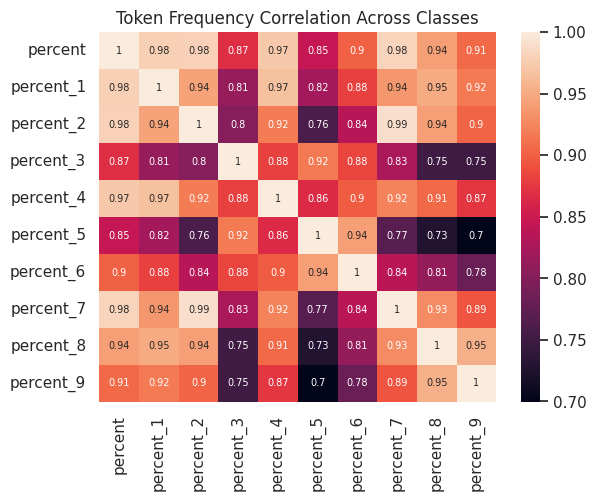

In [117]:
# We can look at token frequency correlation between all classes
pct_cols = [col for col in list(tokens_df.columns) if 'percent' in col]
sns.heatmap(
    tokens_df[pct_cols].corr(), 
    annot=True,
    annot_kws={'size':7})
plt.title('Token Frequency Correlation Across Classes')

# Create modified texts for training/testing, incorporating gene and variation

In [ ]:
X_train = 'Gene: ' + training['Gene'] + '; Variation: ' + training['Variation'] + '; Report: ' + training['Text']
Y_train = training['Class']